In [545]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV



In [546]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [547]:
#欠損値確認
df_train.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [548]:
#型確認
df_train.dtypes

id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [549]:
#口座開設と関係ありそうな仕事がなにか考える
df_train.groupby("job").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
job,,,,,,,,,
admin.,13427.868215,34.592407,47387.572953,16.312206,215.578287,1.855036,432.956072,0.118293,0.086602
blue-collar,13475.960551,34.873762,47290.971630,16.677019,245.964915,1.720329,432.362431,0.070337,0.057915
entrepreneur,13706.757576,36.541126,48195.385281,15.531602,209.969697,1.883983,437.800000,0.053680,0.082251
housemaid,13647.055703,42.201592,46830.530504,15.591512,177.851459,1.874005,431.108753,0.033156,0.090186
management,13485.502619,35.887018,47323.612046,17.944632,248.657314,1.759633,434.258137,0.086420,0.086607
retired,13725.452191,49.158367,48926.679283,15.064741,208.499004,1.672311,422.808765,0.183267,0.167331
self-employed,13578.906277,35.575236,49427.319862,15.891660,195.334480,1.859845,435.653482,0.073947,0.096303
services,13697.905301,34.720761,47448.044516,16.192230,217.862404,1.851882,428.736139,0.069203,0.065965
student,13834.983003,34.427762,44967.872521,15.118980,186.682720,1.507082,424.002833,0.164306,0.294618


studentの割合が最も高く、次点でretired、umemployed(いずれもy=0.1以上)


self-employedとhousemaidにも注意が必要かも(いずれもy=0.9以上)

In [550]:
#口座開設と結婚有無などの関係
df_train.groupby("marital").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
marital,,,,,,,,,
divorced,13647.604928,39.296509,47568.897331,15.210267,204.623819,1.999589,431.675154,0.087885,0.064476
married,13600.095645,36.568972,47757.854142,17.257842,240.617933,1.747225,434.106405,0.073555,0.062511
single,13390.683380,33.741549,47536.572535,16.012394,209.859859,1.769859,428.741549,0.115070,0.120704


singleがmarriedとdivorcedの倍の割合で、口座開設していた

In [551]:
#口座開設と学歴の関係
df_train.groupby("education").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
education,,,,,,,,,
primary,13789.519676,39.841694,47418.426855,15.135476,205.265545,1.882547,431.896966,0.077200,0.065185
secondary,13519.920025,35.168160,47769.221310,17.344218,244.352993,1.738201,432.077154,0.078095,0.064369
tertiary,13463.814606,35.942111,47554.676265,16.213597,206.893870,1.825442,433.697640,0.101529,0.104498
unknown,13781.367933,38.649676,48023.090825,16.232623,221.402224,1.693234,432.693234,0.126043,0.151993


primary（小卒）やsecondary（中卒）といった学歴が低い人はtertiary(高卒)より、口座開設する割合が低い

In [552]:
#口座開設と債務不履行の関係
df_train.groupby("default").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
default,,,,,,,,,
no,13548.088963,36.074013,47680.299705,16.749428,229.34426,1.776043,432.4921,0.085751,0.077962
yes,17372.000000,34.100000,54731.900000,11.700000,178.20000,1.200000,406.2000,0.000000,0.000000


債務不履行になった人はもれなく口座開設していない(出来ていない)

In [553]:
#口座開設と住宅ローン有無の関係
df_train.groupby("housing").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
housing,,,,,,,,,
no,13533.873859,38.738853,47270.851698,15.444464,185.912242,1.890701,432.220548,0.103803,0.130219
yes,13560.643467,34.172388,47976.746950,17.676844,260.284594,1.693912,432.669132,0.072824,0.040647


住宅ローンがない人は、ある人よりも口座開設する割合が３倍以上高い

In [554]:
#口座開設と個人ローンの関係
df_train.groupby("loan").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
loan,,,,,,,,,
no,13526.544248,36.203120,47778.107818,17.067608,235.131453,1.737009,433.525686,0.092850,0.084352
yes,13706.915628,35.182952,47030.040591,14.552914,189.511163,2.042041,425.328211,0.036822,0.033923


個人ローンがない人は、ある人よりも口座開設する割合が2倍以上高い

In [555]:
#口座開設と連絡手段の関係
df_train.groupby("contact").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
contact,,,,,,,,,
cellular,13586.594558,36.280566,47687.660208,17.338278,227.153079,1.805975,432.690970,0.110879,0.091346
telephone,13598.688406,38.822464,47161.988225,12.309783,189.035326,1.858696,435.259964,0.163949,0.089674
unknown,13437.870054,35.050664,47753.565922,15.811505,241.892685,1.678201,431.451599,0.002774,0.038546


連絡手段が分からない人より、わかる人(cellularやtelephone)の方が口座開設する割合が3倍近く高い

In [556]:
#口座開設と前回のキャンペーンの成果の関係
df_train.groupby("poutcome").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
poutcome,,,,,,,,,
failure,13744.464483,36.172249,48572.185499,14.327935,209.125506,1.594038,437.634523,0.461538,0.043798
other,13524.450363,35.428571,48100.884988,13.836562,216.404358,1.886199,418.836562,0.468523,0.048426
success,13636.967249,37.451965,48647.672489,17.336245,247.388646,1.561135,445.596070,1.303493,0.679039
unknown,13525.728949,36.057362,47544.224642,17.124594,231.805273,1.797524,432.104334,0.003680,0.071085


前回キャンペーンで獲得成功?successだった人は、failureやother、unknownよりも口座開設する割合が10倍近く高い

In [557]:
#口座開設と最後に接触した月の成果の関係
df_train.groupby("month").mean()

,id,age,balance,day,duration,campaign,pdays,previous,y
month,,,,,,,,,
apr,13666.326185,35.932170,47375.240399,14.815461,181.244389,1.664838,427.533167,0.245387,0.203491
aug,13608.113872,38.581781,46971.379769,14.516415,155.894706,2.157054,429.996155,0.012422,0.068323
feb,13536.998153,37.188366,47878.610342,11.175439,168.312096,1.735919,445.370268,0.254848,0.148661
jan,12801.445983,36.778393,48464.551247,24.601108,224.024931,1.903047,441.753463,0.091413,0.127424
jul,13432.342909,37.130027,47375.905050,12.468400,193.369217,2.167221,422.190807,0.066526,0.086786
jun,13484.191186,37.457874,47994.884964,10.875891,190.963707,1.672715,439.343487,0.017498,0.057032
mar,13795.439252,41.514019,48337.757009,18.144860,286.289720,1.369159,416.579439,0.392523,0.462617
may,13562.132657,34.151442,47898.707799,20.595709,298.674590,1.605324,432.033298,0.062322,0.044160
nov,13595.220633,37.172085,47956.519723,17.966623,168.323364,1.766363,441.167750,0.150845,0.062852


10月が最も高く半数超え、次点で3月、9月

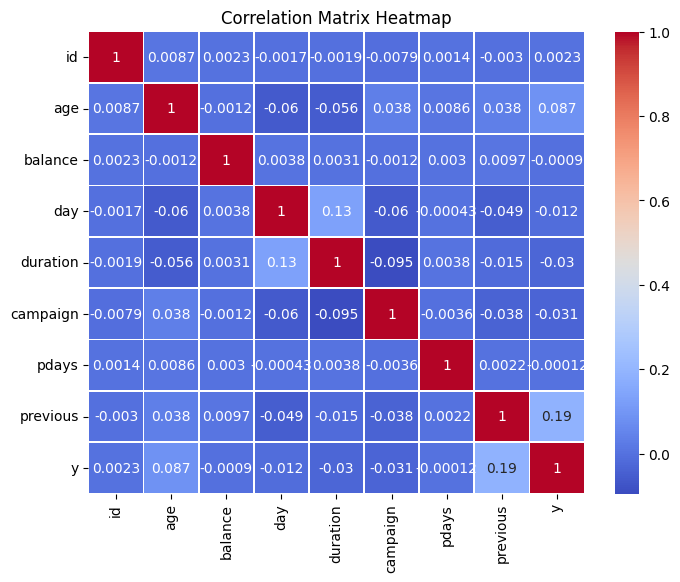

In [558]:
#数字系は相関行列で見る
correlation_matrix = df_train.corr()

# ヒートマップを作成
plt.figure(figsize=(8, 6))  # サイズを指定
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

# タイトルを追加
plt.title('Correlation Matrix Heatmap')

# ヒートマップを表示
plt.show()

previous(現キャンペーン以前までに顧客に接触した回数)との相関が最も高い
年齢もやや関係あるかも？(retiredとstudentの影響もありそう)

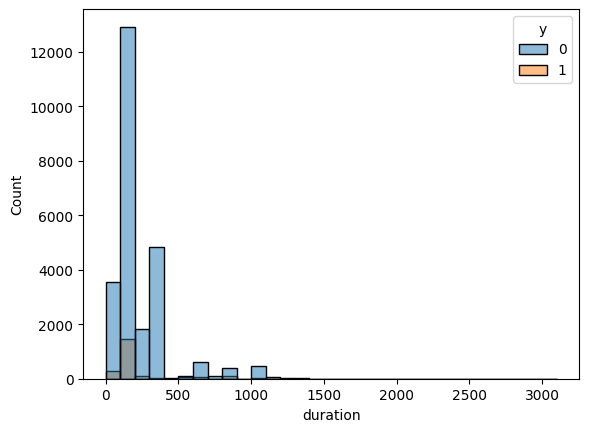

In [559]:
#durationを見える化
sns.histplot(data = df_train,x="duration",binwidth=100,bins = range(0,3000),kde=False,hue="y")
plt.show()

最終接触時間が短いほど参加しやすいのかもしれない....?

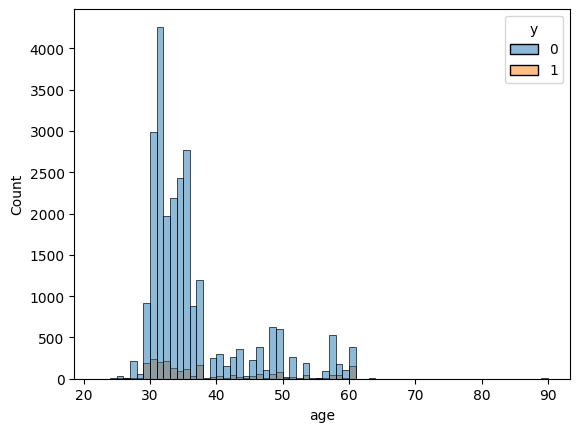

In [560]:
#口座開設とageの関係を見える化
sns.histplot(data = df_train,x="age",binwidth=1,bins = range(0,20),kde=False,hue="y")
plt.show()

10代、20代は特に口座開設する割合が大きい？

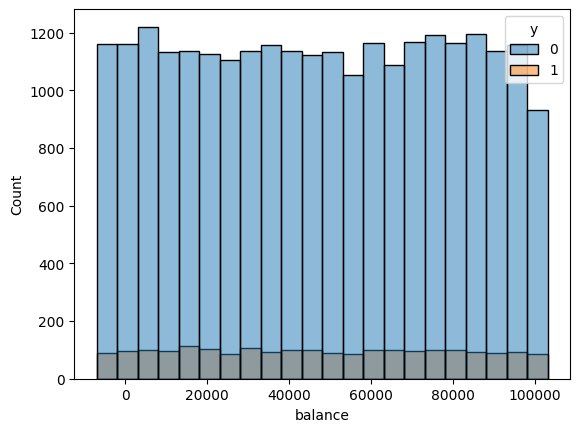

In [561]:
#口座開設と年間平均残高を見える化
sns.histplot(data = df_train,x="balance",binwidth=5000,bins = range(0,1000),kde=False,hue="y")
plt.show()

微妙.....使えないかも

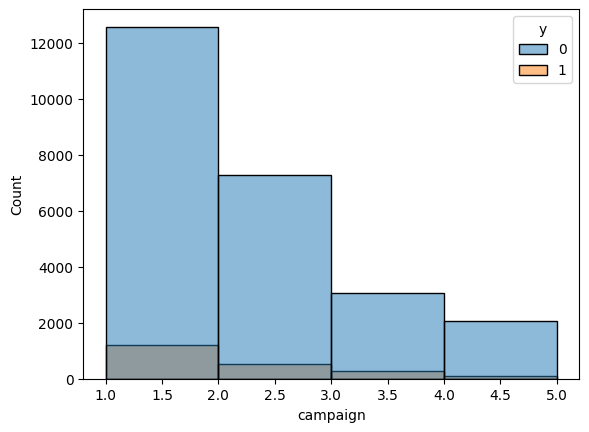

In [562]:
#口座開設とキャンペーン接触回数を見える化
sns.histplot(data = df_train,x="campaign",binwidth=1,bins = range(0,30),kde=False,hue="y")
plt.show()

入れといてもいいのかこれは...

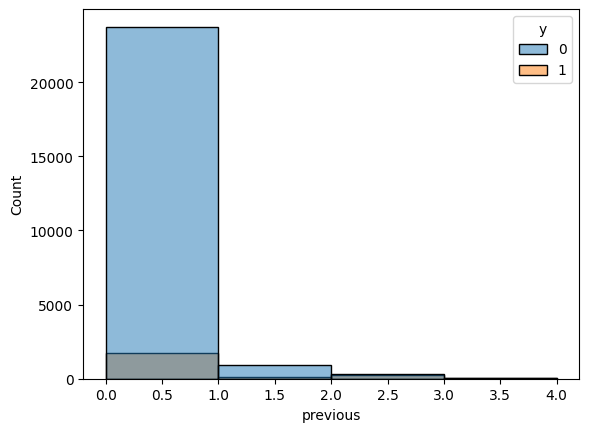

In [563]:
#口座開設と現キャンペーン以前までに接触回数を見える化
sns.histplot(data = df_train,x="previous",bins = range(0,5),kde=False,hue="y")
plt.show()

2回以上接触している人の口座解説率は高い

In [564]:
#見える化した結果からデータを加工

#20代以下のみの特徴量作成
df_train["under20"] = (df_train['age'] < 30).astype(int)
df_test["under20"] = (df_test['age'] < 30).astype(int)

#現キャンペーン以前までの接触回数が2回以上
df_train["campaign_over2"] = (df_train["campaign"] > 1).astype(int)
df_test["campaign_over2"] = (df_test["campaign"] > 1).astype(int)


In [565]:
#以上の結果からデータを加工して、一回予測モデルを作って精度を検証

# ダミー変数作成
df_train = pd.get_dummies(df_train)
print(df_train.columns)

df_test = pd.get_dummies(df_test)
df_test.columns

# ageが30歳未満 かつ studentの場合は1, そうでなければ0
df_train['age_student'] = ((df_train['age'] < 30) & (df_train['job_student'] == 1)).astype(int)
df_test['age_student'] = ((df_test['age'] < 30) & (df_test['job_student'] == 1)).astype(int)

Index(['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y', 'under20', 'campaign_over2', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [566]:
#対数化して特徴量のスケールを調整
df_train["age"] = np.log(df_train["age"])
df_train["previous"] = np.log(df_train["previous"]+1)
df_train["balance"] = np.log(df_train['balance'] - df_train['balance'].min() + 1)
df_train["duration"] = np.log(df_train["duration"]+1)

#テストにも適用
df_test["age"] = np.log(df_test["age"])
df_test["previous"] = np.log(df_test["previous"]+1)
df_test["balance"] = np.log(df_test['balance'] - df_test['balance'].min() + 1)
df_test["duration"] = np.log(df_test["duration"]+1)

In [567]:
#クロスバリデーションを利用
# 特徴量とターゲット変数を分ける
X = df_train.drop('y', axis=1)  # 'target'列を除く全ての列が特徴量
y = df_train['y']  # 'target'列がラベル

# Stratified K-Foldの設定
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#ハイパーパラメータの設定
param_grid = {}

In [568]:
# 特徴量を自動で抽出
# RFECVを使用
rfe = RFECV(estimator=GradientBoostingRegressor(random_state=42), step=0.5)

# 特徴量削減の実行
rfe.fit(X, y)

# 削減実行後のデータを再構成
rfeData = pd.DataFrame(rfe.transform(X), columns=X.columns.values[rfe.support_])

print(rfeData.columns)

X = rfeData

Index(['id', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'under20', 'campaign_over2', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown',
       'month_apr', 'month_aug', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_student'],
      dtype='object')


In [569]:
#モデルのfitとaucのテスト評価結果出力関数
def prob_auc_validation(model,x,y,param_grid):
    # RandomizedSearchCVの設定（試行する組み合わせの数を10に制限）
    random_search = RandomizedSearchCV(
        model, param_grid, n_iter=10, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42
    )
    random_search.fit(x,y)
    # 最適なハイパーパラメータを表示
    print("Best parameters found: ", random_search.best_params_)
    best_model = random_search.best_estimator_
    probs = best_model.predict_proba(x)[:, 1]
    # probs = best_model.predict(x)
    auc = roc_auc_score(y, probs)
    return [auc,best_model]

In [570]:
# ランダムフォレスト分類器の初期化
rf_classifier = RandomForestClassifier(random_state=42)
# ハイパーパラメータの範囲
param_grid = {
    'n_estimators': [100, 150],  # 決定木の数
    'max_depth': [None, 10, 20],  # ツリーの最大深さ
    'min_samples_split': [2, 5],  # 内部ノードを分割するために必要なサンプルの最小数
    'min_samples_leaf': [1, 2],  # 葉を形成するために必要なサンプルの最小数
    'bootstrap': [True],  # ブートストラップサンプルを使用するかどうか
}
rf_bestmodel = prob_auc_validation(rf_classifier,X,y,param_grid)[1]
rf_auc = prob_auc_validation(rf_classifier,X,y,param_grid)[0]

Best parameters found:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
Best parameters found:  {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}


In [571]:
# XGBoost分類器の初期化
xgb_classifier = xgb.XGBClassifier(random_state=42,reg_lambda = 1)
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_child_weight': [1, 2, 3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8,0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],  # gammaの推奨値
}
xgb_bestmodel = prob_auc_validation(xgb_classifier,X,y,param_distributions)[1]
xgb_auc = prob_auc_validation(xgb_classifier,X,y,param_distributions)[0]

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 133, 'subsample': 1}
Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 133, 'subsample': 1}


In [572]:
# ロジスティック回帰
logistic_model = LogisticRegression(random_state=42)
param_distributions = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

logistic_bestmodel = prob_auc_validation(logistic_model,X,y,param_distributions)[1]
logistic_auc = prob_auc_validation(logistic_model,X,y,param_distributions)[0]

/Users/postkershaw/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/postkershaw/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/postkershaw/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS RE

Best parameters found:  {'penalty': 'l2', 'C': 10}


/Users/postkershaw/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/postkershaw/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/postkershaw/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS RE

Best parameters found:  {'penalty': 'l2', 'C': 10}


In [573]:
# k-最近傍法 (k-NN)
knn_model = KNeighborsClassifier(n_neighbors=5)
param_distributions = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}
knn_bestmodel = prob_auc_validation(knn_model,X,y,param_distributions)[1]
knn_auc = prob_auc_validation(knn_model,X,y,param_distributions)[0]

Best parameters found:  {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'ball_tree'}
Best parameters found:  {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'ball_tree'}


In [574]:
# GBDTモデルを初期化
gbdt_model = GradientBoostingClassifier(random_state=42,n_iter_no_change=20,tol=0.001)

# ハイパーパラメータの分布を設定
param_distributions = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01,0.05, 0.1],
    'max_depth': randint(3, 8),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)                 
}

gbdt_bestmodel = prob_auc_validation(gbdt_model,X,y,param_distributions)[1]
gbdt_auc = prob_auc_validation(gbdt_model,X,y,param_distributions)[0]

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 67}
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 67}


In [575]:
#auc評価結果
print(f'Random Forest AUC: {rf_auc:.3f}')
print(f'XGBoost AUC: {xgb_auc:.3f}')
# print(f"GBM AUC: {gbm_auc}")
print(f"Logistic Regression AUC: {logistic_auc}")
print(f"KNN AUC: {knn_auc}")
print(f"gbdt: {gbdt_auc}")

Random Forest AUC: 0.990
XGBoost AUC: 0.960
Logistic Regression AUC: 0.7454035133833936
KNN AUC: 0.8812727741891866
gbdt: 0.9283957435932882


In [576]:
#テストの実行
variables = rfeData.columns

df_test_test = df_test[variables]

#やっぱりxgboostとlightgbmは外さない
# predicted_probabilities = gbm_bestmodel.predict_proba(df_test_test)[:, 1]
predicted_probabilities = xgb_bestmodel.predict_proba(df_test_test)[:, 1]

In [577]:
# 予測結果を新しいデータフレームに追加
#テストの実行
test_ids = df_test["id"].copy()

output = pd.DataFrame({'id': test_ids, 'prediction': predicted_probabilities})
output

# CSVファイルとして出力
output.to_csv('submit.csv', index=False)